# Meta Features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


## Categorical Encoders

In [3]:
import category_encoders as ce

encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.polynomial.PolynomialEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]

In [4]:
from src.features.basic import features
from src.features.common import postproc_categorical, read_non_sensor_data
from src.featutils import combine
from src.dataset.tc4tl import make_datasets
import category_encoders as ce

trainset, devset, testset = make_datasets(combine(features, read_non_sensor_data),
                                          postproc_categorical, verbose=True, testing=0,
                                          tunables={ 
                                              "CategoricalEncoder" : ce.polynomial.PolynomialEncoder
                                          })

100%|████████████████████████████████████| 15552/15552 [00:28<00:00, 539.64it/s]


NO Pipe input given!


100%|████████████████████████████████████████| 935/935 [00:01<00:00, 545.86it/s]


Pipe input given!


100%|██████████████████████████████████████| 8423/8423 [00:14<00:00, 563.91it/s]

Pipe input given!


In [5]:
predictors = []
for col in trainset.columns:
    if "Rssi" in col or "Coarse" in col or "_" in col:
        predictors.append(col)
predictors

['RssiMin',
 'RssiPercentile:1',
 'RssiPercentile:5',
 'RssiPercentile:10',
 'RssiPercentile:25',
 'RssiPercentile:40',
 'RssiMean',
 'RssiPercentile:65',
 'RssiPercentile:80',
 'RssiPercentile:90',
 'RssiPercentile:95',
 'RssiPercentile:99',
 'RssiMax',
 'CoarseGrain',
 'Cat:TXDevice_0',
 'Cat:TXDevice_1',
 'Cat:TXDevice_2',
 'Cat:TXDevice_3',
 'Cat:TXDevice_4',
 'Cat:TXDevice_5',
 'Cat:TXDevice_6',
 'Cat:TXDevice_7',
 'Cat:TXDevice_8',
 'Cat:TXDevice_9',
 'Cat:TXDevice_10',
 'Cat:TXDevice_11',
 'Cat:TXDevice_12',
 'Cat:TXDevice_13',
 'Cat:TXPower_0',
 'Cat:TXPower_1',
 'Cat:RXDevice_0',
 'Cat:RXDevice_1',
 'Cat:RXDevice_2',
 'Cat:RXDevice_3',
 'Cat:RXDevice_4',
 'Cat:RXDevice_5',
 'Cat:RXDevice_6',
 'Cat:RXDevice_7',
 'Cat:RXDevice_8',
 'Cat:TXCarry_0',
 'Cat:RXCarry_0',
 'Cat:RXPose_0',
 'Cat:TXPose_0']

In [6]:
from src.models.evaluate import dual_evaluation
import pandas as pd
from src.ndcf import compute_ndcf

report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset,
                    predictors=predictors,
                    target="Distance")
ndcf = compute_ndcf(sysout)
ndcf["nDCF"].mean()

0.21526295072008989

In [8]:
ndcf

,Subset,Distance,P_miss,P_fa,nDCF
0,fine_grain,1.2,0.218195,0.038645,0.256840
1,fine_grain,1.8,0.127531,0.057112,0.184643
2,fine_grain,3.0,0.075952,0.223731,0.299684
3,coarse_grain,1.8,0.092762,0.027123,0.119885


In [10]:
print(report["cg=0"])

              precision    recall  f1-score   support

         1.8       0.97      0.91      0.94      1423
         4.5       0.91      0.97      0.94      1401

    accuracy                           0.94      2824
   macro avg       0.94      0.94      0.94      2824
weighted avg       0.94      0.94      0.94      2824



In [11]:
print(report["cg=1"])

              precision    recall  f1-score   support

         1.2       0.87      0.78      0.82      1407
         1.8       0.83      0.80      0.82      1408
         3.0       0.71      0.81      0.76      1385
         4.5       0.77      0.78      0.77      1399

    accuracy                           0.79      5599
   macro avg       0.80      0.79      0.79      5599
weighted avg       0.80      0.79      0.79      5599



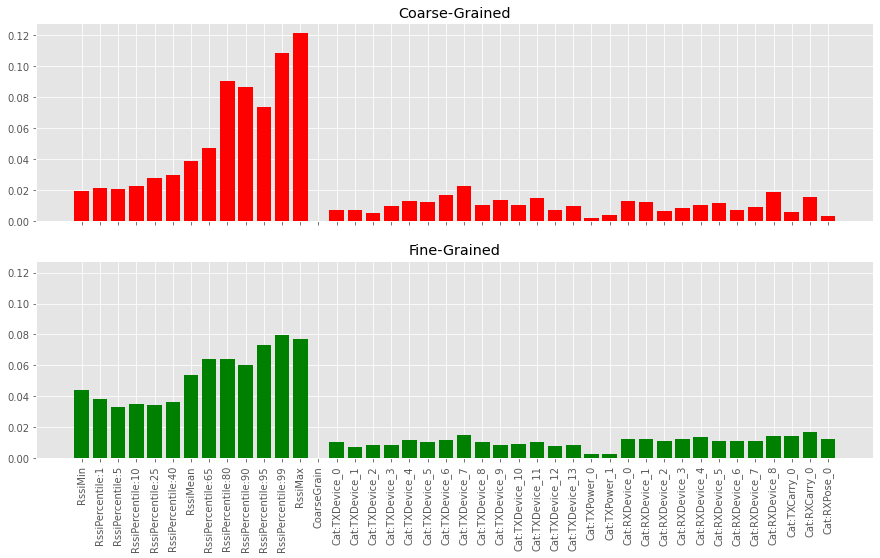

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

m0, m1 = report["model:cg=0"], report["model:cg=1"]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(15, 8))
ax0, ax1 = axes.flatten()
ax0.bar(predictors[:-1], m0.feature_importances_[:-1], color="red")
ax0.set_title("Coarse-Grained")
ax0.tick_params(axis='x', rotation=90)
ax1.bar(predictors[:-1], m1.feature_importances_[:-1], color='green')
ax1.set_title("Fine-Grained")
ax1.tick_params(axis='x', rotation=90)